# Stéréovision

![Suzanne](main.png)

La stéréovision est une discipline qui s’occupe de reconstruire des informations 3D à partir d’images. Ppour que la reconstruction d’un point soit possible, il faut plusieurs images de ce point. Ces images doivent être prises de points de vue différents. L’étape clé de la reconstruction, qui pose souvent problème, est d’indentifier l’image du point à reconstruire dans chacune des vues.

## Géométrie épipolaire

La géométrie épipolaire fait intervenir deux caméras. La géométrie épipolaire décrit les propriétés géométriques entre deux vues d’une même scène et ne dépend que des paramètres intrinsèques des caméras et de leurs positions relatives. Elle fournit, en particulier, la contrainte épipolaire, qui nous sera très utile pour produire les appariements entre vues.

## La matrice fondamentale

![Géométrie épipolaire - Sanyam Kapoor](https://i.imgur.com/GbafZIY.png)

Imaginons que nous ayons deux images, droite et gauche, de l’espace monde. Prenons un point $\vec{x}$ dans l’espace image droit. Le point $\vec{X}$ de l’espace monde, dont $\vec{x}$ est l’image, peut se trouver n’importe où sur la droite passant par $\vec{x}$ et le centre optique de la caméra de droite. Nous appellerons cette droite, le rayon retro-projeté de $\vec{x}$. Notons $\vec{x}'$ l’image de $\vec{X}$ dans l’espace image gauche. Le lieu de $\vec{x}'$ est donc la droite image du rayon retro-projeté de $\vec{x}$. Cette droite est appelée ligne épipolaire et notée $\vec{l}'$. La ligne épipolaire passe par l’épipole $\vec{e}'$, image du centre optique de la caméra de droite.

En géométrie projective 2D, une droite d’équation $ax+by+c = 0$ est représentée par un vecteur à trois composantes $(a, b, c)^T$ définies à un facteur près. On a donc la relation suivante:

>Le point $\vec{x}$ appartient à la droite $\vec{l}$ si et seulement si $x^T\vec{l} = 0$.

De plus, en géométrie projective 2D, les relations remarquables suivantes sont valables:

- L’intersection de deux lignes $l$ et $l'$ est donnée par $x = l \times l'$,
- La droite passant par deux points $x$ et $x'$ est donnée par $l = x \times x'$.

Notons que le produit vectoriel peut être écrit comme un produit de matrice $x \times y = [x]_\times y$ où

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

Pour trouver l’équation de la ligne épipolaire dans l’espace image gauche, il nous suffit donc de trouver les coordonnées de deux points de cette ligne. Le premier est l’image $P'\vec{C}$ du centre optique $\vec{C}$ de la caméra de droite où $P'$ est la matrice de projection de la caméra de gauche. Le deuxième est $P'P^{+}\vec{x}$ où $P^{+}$ est la pseudo inverse de la matrice de projection $P$ de la caméra de droite. La ligne épipolaire a donc pour équation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ avec $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ est appelée matrice fondamentale.

Comme la ligne épipolaire $\vec{l}' = F\vec{x}$ est le lieu de $\vec{x}'$, $\vec{x}'$ appartient donc à $\vec{l}'$ ce qui conduit à la contrainte épipolaire :

>**La matrice fondamentale est telle que pour toute paire de points se correspondant $\vec{x} \leftrightarrow \vec{x}'$ dans les deux images, on a $\vec{x}'^{T}F\vec{x} = 0$.**

## Calcul de la matrice fondamentale

La matrice fondamentale $F$ a sept degrés de liberté. Elle possède neuf composantes mais celles-ci sont définies à un facteur d’échelle près, ce qui enlève un degré de liberté. De plus, la matrice $F$ est une matrice singulière ($det(F) = 0$) ce qui nous fait bien sept degrés de liberté. Il nous faut donc sept correspondances minimum pour calculer $F$. L’équation $x'^{T}_iFx_i = 0$ et les sept correspondances nous permettent d’écrire un système d’équations de la forme $Af = 0$, où $f$ est le vecteur qui contient les composantes de la matrice $F$. Admettons que $A$ soit une matrice 7×9 de rang 7. La solution générale de $Af = 0$ peut s’écrire $\alpha f_1 + (1−\alpha) f_2$ où $f_1$ et $f_2$ sont deux solutions particulières indépendantes de $Af = 0$. On utilise ensuite la contrainte de singularité $det(\alpha F_1 + (1 − \alpha)F_2) = 0$ pour déterminer $\alpha$. La contrainte de singularité donnant lieu à une équation du troisième degré, on pourra avoir une ou trois solutions pour $F$.

## OpenCV

En pratique vous allez utiliser la bibliothèque OpenCV. En python, vous avez accès à ses fonctions grâce au module `cv2`.

Vous pouvez trouver de l'aide concernant les fonctions de calibration et de reconstruction à la page https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html

## Objectif

Dans le zip de l'énoncé vous trouverez deux séquences d'images prise par deux caméras pendant le balayage d'un objet par un plan laser.

![Laser](scanRight/scan0010.png)

Vous trouverez également des prises de vue d'un damier dans différentes position qui vous aideront à calibrer vos caméras.

![Damier](chessboards/c2Right.png)

Le but est de reconstruire en 3D l'objet scanné.

In [1]:
import numpy as np
from matplotlib import pyplot as plt, image as mpimg
import cv2
from pathlib import Path
import stereo as s
from ipywidgets import interact

In [2]:
chessboards = [
    cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_RGB2GRAY) for path in Path("chessboards").iterdir()
]
chessboards_size = (7, 7)

In [3]:
imageSize = chessboards[0].shape
print(imageSize)

(1080, 1920)


In [4]:
objp = s.objectpoints_for_chessboard(chessboards_size)

In [5]:
imgpoints = []
objpoints = [objp] * len(chessboards)
for i, board in enumerate(chessboards):
    corners = s.imgpoints_for_chessboard(board, chessboards_size)
    if corners is not None:
        imgpoints.append(corners)

        print(f"Found on {i}")
        # s.show_chessboard_corners(board, corners, chessboards_size)
    else:
        del objpoints[0]
        print(f"Not found on {i}")

Found on 0
Found on 1
Found on 2
Found on 3
Not found on 4
Not found on 5
Found on 6
Found on 7


In [6]:
ret, camera_matrix, distortion, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, board.shape[::-1], None, None)
print("Camera matrix :")
print(camera_matrix)
print("\ndistortion coefficients :")
print(distortion)
# print("\nrotation vectors :")
# for rvec in rvecs:
#     print(rvec)
# print("\ntranslation vectors :")
# for tvec in tvecs:
#     print(tvec)

Camera matrix :
[[2.09964014e+03 0.00000000e+00 9.59851706e+02]
 [0.00000000e+00 2.09964789e+03 5.39214662e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

distortion coefficients :
[[-7.82875224e-03  2.77751258e-01 -1.03966646e-04  6.10133990e-05
  -2.73003495e+00]]


In [7]:
(
    retval, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F
) = cv2.stereoCalibrate(objpoints[:3], imgpoints[::2], imgpoints[1::2], camera_matrix, distortion, camera_matrix, distortion, imageSize)

print("R:\n", R)
print("T:\n", T)
print("F:\n", F)

R:
 [[ 0.94530749  0.01016427  0.32602215]
 [-0.01261086  0.99990594  0.00539174]
 [-0.32593668 -0.00920827  0.94534676]]
T:
 [[-7.04388011]
 [-0.1157464 ]
 [ 0.97032461]]
F:
 [[-3.90634714e-08  7.57744576e-07 -1.82877398e-04]
 [ 1.07786270e-06  4.30011337e-08 -1.25083961e-02]
 [-8.69146080e-04  1.08097456e-02  1.00000000e+00]]


In [8]:
(
    R1, R2, P1, P2, Q, validPixROI1, validPixROI2
) = cv2.stereoRectify(cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, imageSize, R, T)

In [9]:
maps1 = cv2.initUndistortRectifyMap(cameraMatrix1, distCoeffs1, R1, P1, (imageSize[1], imageSize[0]), cv2.CV_16SC2)
maps2 = cv2.initUndistortRectifyMap(cameraMatrix2, distCoeffs2, R2, P2, (imageSize[1], imageSize[0]), cv2.CV_16SC2)

Schedule computations in nested generators

In [10]:
scanLeft = (
    cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_HSV2RGB) for path in Path("scanLeft").iterdir()
)
scanRight = (
    cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_HSV2RGB) for path in Path("scanRight").iterdir()
)

In [11]:
scanLeft = (
    cv2.inRange(img, np.array([200, 200, 100]), np.array([255, 255, 255])) for img in scanLeft
)
scanRight = (
    cv2.inRange(img, np.array([200, 200, 100]), np.array([255, 255, 255])) for img in scanRight
)

In [12]:
scanLeft = (
    cv2.remap(img, *maps1, cv2.INTER_LINEAR) for img in scanLeft
)
scanRight = (
    cv2.remap(img, *maps2, cv2.INTER_LINEAR) for img in scanRight
)

In [13]:
scanLeft = (
    s.skel(img) for img in scanLeft
)
scanRight = (
    s.skel(img) for img in scanRight
)

In [14]:
# Run generators
scanLeft = list(scanLeft)
scanRight = list(scanRight)

In [15]:
# Uncomment to show all left images one by one

# for i, img in enumerate(scanLeft):
#     print(i)
#     plt.figure(figsize=(15, 15))
#     plt.imshow(img, cmap='gray')
#     plt.show()

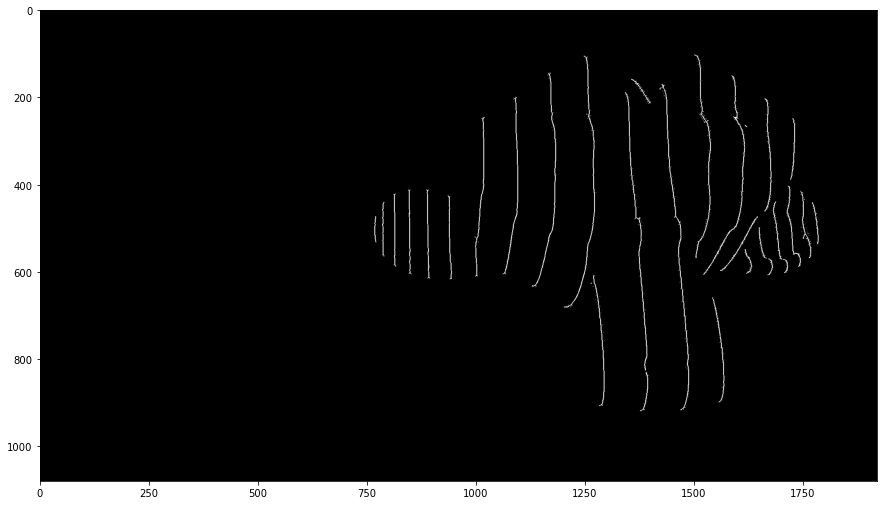

In [16]:
# Show all left images in one
left = np.zeros(imageSize)
for img in scanLeft:
    left = np.logical_or(left, img)
plt.figure(figsize=(15, 15))
plt.imshow(left, cmap='gray')
plt.show()

In [17]:
# Uncomment to show all right images one by one

# for i, img in enumerate(scanRight):
#     print(i)
#     plt.figure(figsize=(15, 15))
#     plt.imshow(img, cmap='gray')
#     plt.show()

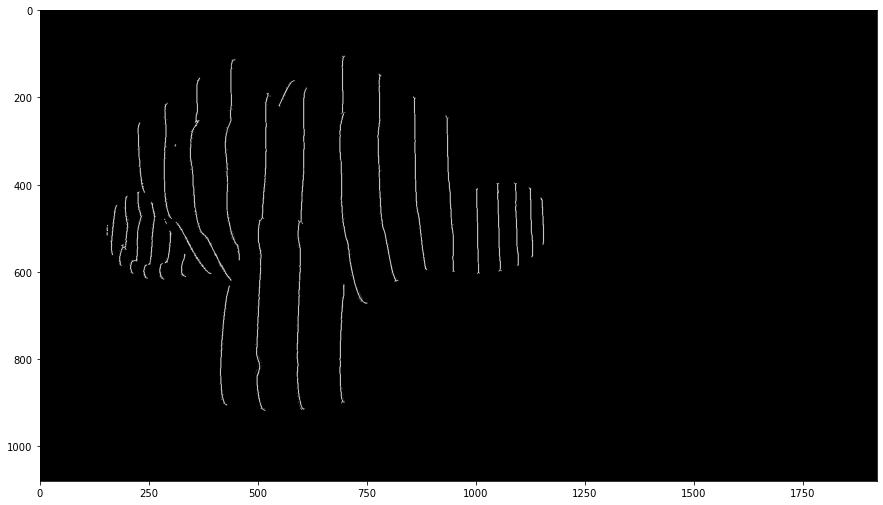

In [18]:
# Show all right images in one
right = np.zeros(imageSize)
for img in scanRight:
    right = np.logical_or(right, img)
plt.figure(figsize=(15, 15))
plt.imshow(right, cmap='gray')
plt.show()

In [19]:
# Create a set of lines to sample
line_interval = 10  # px

blank = np.zeros((imageSize[0]-1, imageSize[1]), dtype='bool')
line = np.ones((1, imageSize[1]), dtype='bool')

lines = [
    np.insert(blank, place, line, axis=0) for place in range(0, left.shape[0], line_interval)
]

In [20]:
# Uncomment to plot a single line

# plt.figure(figsize=(15, 15))
# plt.imshow(lines[2], cmap='gray')
# plt.show()

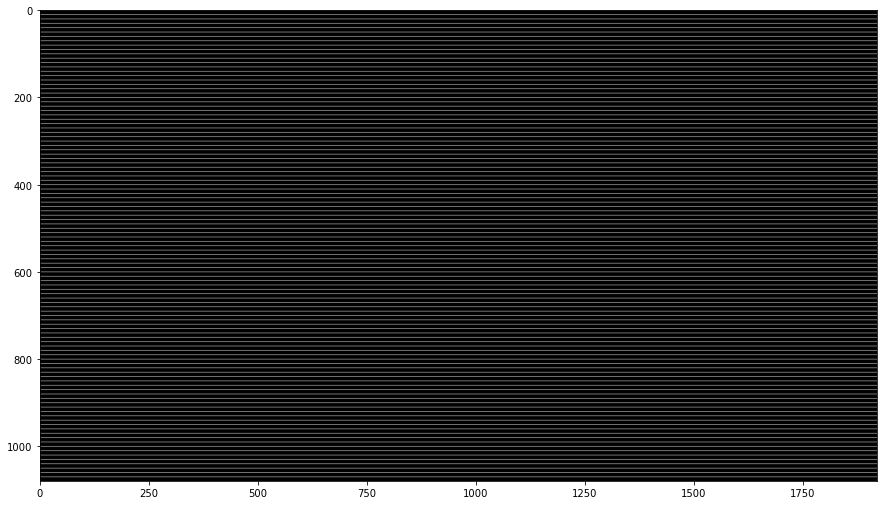

In [21]:
# Plot all sample lines at once

horizontals = np.zeros(lines[0].shape)
for img in lines:
    horizontals = np.logical_or(horizontals, img)
plt.figure(figsize=(15, 15))
plt.imshow(horizontals, cmap='gray')
plt.show()

In [22]:
# Sample a couple of images and count the pixels

l = scanLeft[4]
r = scanRight[4]
gl = horizontals & l
gr = horizontals & r

print(np.sum(gl), np.sum(gr))

26 26


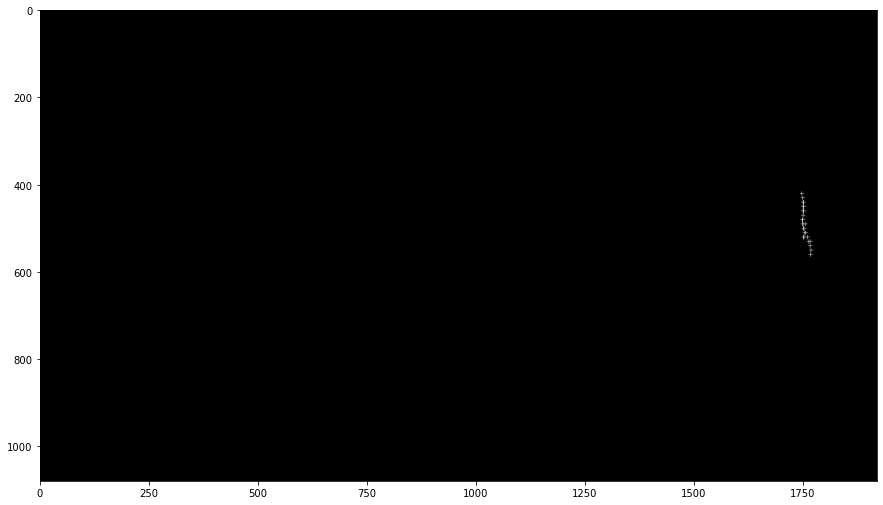

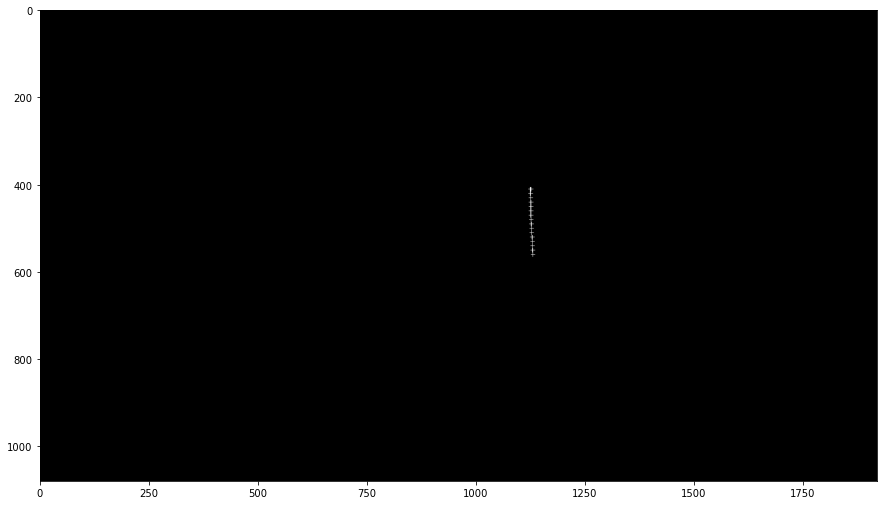

In [23]:
# make the sampled pixels bigger and show them
tmp = cv2.dilate(gl, cv2.getStructuringElement(cv2.MORPH_CROSS,(10,10)))
plt.figure(figsize=(15, 15))
plt.imshow(tmp, cmap='gray')
plt.show()
tmp = cv2.dilate(gr, cv2.getStructuringElement(cv2.MORPH_CROSS,(10,10)))
plt.figure(figsize=(15, 15))
plt.imshow(tmp, cmap='gray')
plt.show()

In [24]:
# Sample all images, line by line, and keep only the leftmost coordinate

points_l_tmp = []
points_r_tmp = []

for line in lines:
    for l, r in zip(scanLeft, scanRight):
        point_l = line & l
        point_r = line & r
        
        nzl = np.transpose(point_l.nonzero())
        nzr = np.transpose(point_r.nonzero())
        
        if len(nzl) and len(nzr):
            points_l_tmp.append(nzl[0])
            points_r_tmp.append(nzr[0])

In [25]:
# Make these coordinates into float arrays
points_l = np.array(points_l_tmp, dtype=float)
points_r = np.array(points_r_tmp, dtype=float)

print("Left:\n", points_l.T)
print("Right:\n", points_r.T)

Left:
 [[ 110.  120.  120. ...  900.  900.  910.]
 [1509. 1512. 1254. ... 1389. 1289. 1385.]]
Right:
 [[110. 120. 120. ... 900. 900. 910.]
 [695. 693. 440. ... 504. 423. 508.]]


In [26]:
# Triangulate the points in homogenous space
points4D = cv2.triangulatePoints(P1, P2, points_l[:].T, points_r[:].T)

In [27]:
points4D.shape

(4, 633)

In [28]:
# Get back into plain 3D
points3D = cv2.convertPointsFromHomogeneous(points4D.T)

In [29]:
points3D = points3D.squeeze()

And now we show the monkey without any rotation/translation, undistorted, reconstructed from the points

In [30]:
points2D, jac = cv2.projectPoints(points3D, (0, 0, 0), (0, 0, 0), camera_matrix, ())

In [31]:
points2D = np.array(points2D, dtype=int).squeeze()

In [32]:
points2D.T

array([[ 108,  117,  116, ...,  949,  949,  960],
       [1124, 1125,  862, ...,  969,  874,  969]])

In [33]:
m0, m1 = np.min(points2D.T[0]), np.min(points2D.T[1])
print(m0, m1)

108 463


In [34]:
# Move the image in frame, to avoid overflow
points2D.T[0] += -m0
points2D.T[1] += -m1

In [35]:
M0, M1 = np.max(points2D.T[0]), np.max(points2D.T[1])
print(M0, M1)

852 1029


In [36]:
out = np.zeros((M0+1, M1+1))

for x, y in points2D:
    out[x, y] = 255

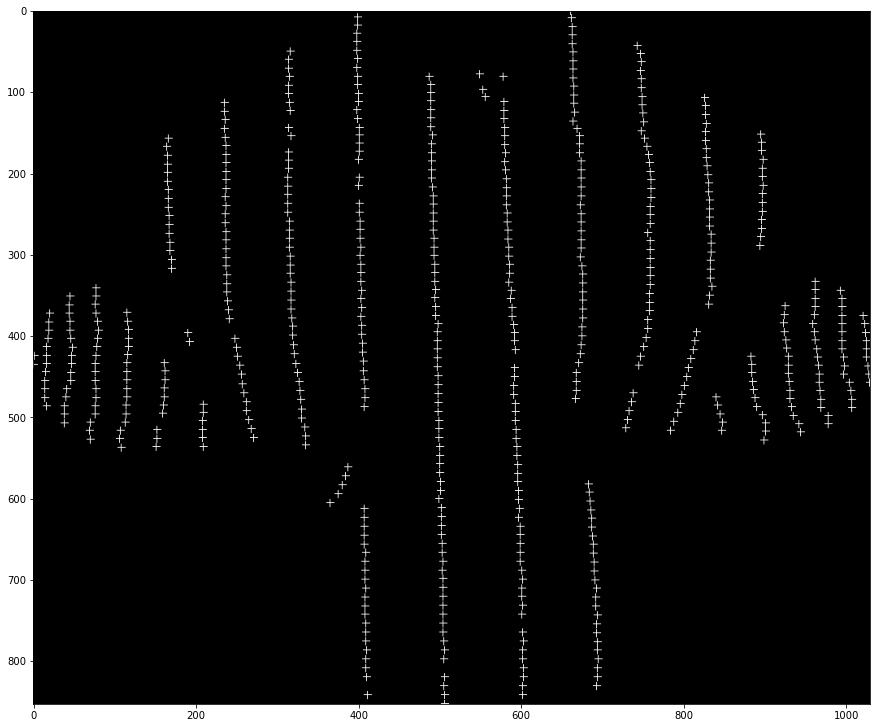

In [37]:
tmp = cv2.dilate(out, cv2.getStructuringElement(cv2.MORPH_CROSS,(10,10)))
plt.figure(figsize=(15, 15))
plt.imshow(tmp, cmap='gray')
plt.show()

In [38]:
# You can interact with the slider to rotate the monkey around axis

@interact(x=(-0.7, 1.1), y=(-0.6, 1.), z=(-3.2, 3.2))
def c(x=0, y=0, z=0):
    points2D, jac = cv2.projectPoints(points3D, (x, y, z), (0, 0, 0), camera_matrix, ())
    points2D = np.array(points2D, dtype=int).squeeze()
    m0, m1 = np.min(points2D.T[0]), np.min(points2D.T[1])
    points2D.T[0] += -m0
    points2D.T[1] += -m1
    M0, M1 = np.max(points2D.T[0]), np.max(points2D.T[1])
    out = np.zeros((M0+1, M1+1))

    for x, y in points2D:
        out[x, y] = 255
    tmp = cv2.dilate(out, cv2.getStructuringElement(cv2.MORPH_CROSS,(10,10)))
    plt.figure(figsize=(15, 15))
    plt.imshow(tmp, cmap='gray')
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='x', max=1.1, min=-0.7), FloatSlider(value=0.0, descr…